In [1]:
library(zoo)
library(forecast)

Warning message:
"package 'zoo' was built under R version 3.3.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'forecast' was built under R version 3.3.3"

In [2]:
data_dir <- "C:/Users/Tom/Documents/research/alc-summary"

In [3]:
preprocessing <- function(ts_csv, total_csv, thres=5000){
  
  # removes rows with low observations and locfs them
  # returns time series and total time series, as a list
  
  
  ts = read.csv(ts_csv)
  total <- read.csv(total_csv)
  df = time_index(data.frame(ts))
  df_total = time_index(data.frame(total))
  
  missing = df_total[,'tweets']<thres
  print(which(missing))
  df_total[missing, 'tweets'] <- NA
  df[missing,] <-NA
  df_total = na.locf(df_total[,'tweets'])
  df_filled = (na.locf(df[, ncol(df)]))
  
  return(list(series=df_filled, total=df_total))
}

In [4]:
time_index <- function(df){
  #indexes a dataframe by 30 days and 24 hours
  
  times = data.frame()
  for (d in 1:30){
    for (h in 0:23){
      times = rbind(times, c(d, h, 0))
    }
  }
  colnames(times) = c('day', 'hour', 'tweets')
  colnames(df) = c('day', 'hour', 'tweets')
  merged = merge(times, df, by=c('day', 'hour'), all='TRUE')
  merged[is.na(merged)] = 0
  merged['tweets'] = pmax(merged$tweets.x,merged$tweets.y)
  return (merged)
}


In [5]:
series.std <- function(count, tot){
        # calculate variance of perc as mean of iid rvs (count 1s, tot-count 0s)
        # WE USE CLT
        perc <- count/tot
        # E(X)^2 - E(X)^2
        var <- count/tot - perc*perc
        # CLT: std (y_bar = std(y)/sqrt(n))
        return (sqrt(var)/sqrt(tot))
}

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


png 
  2

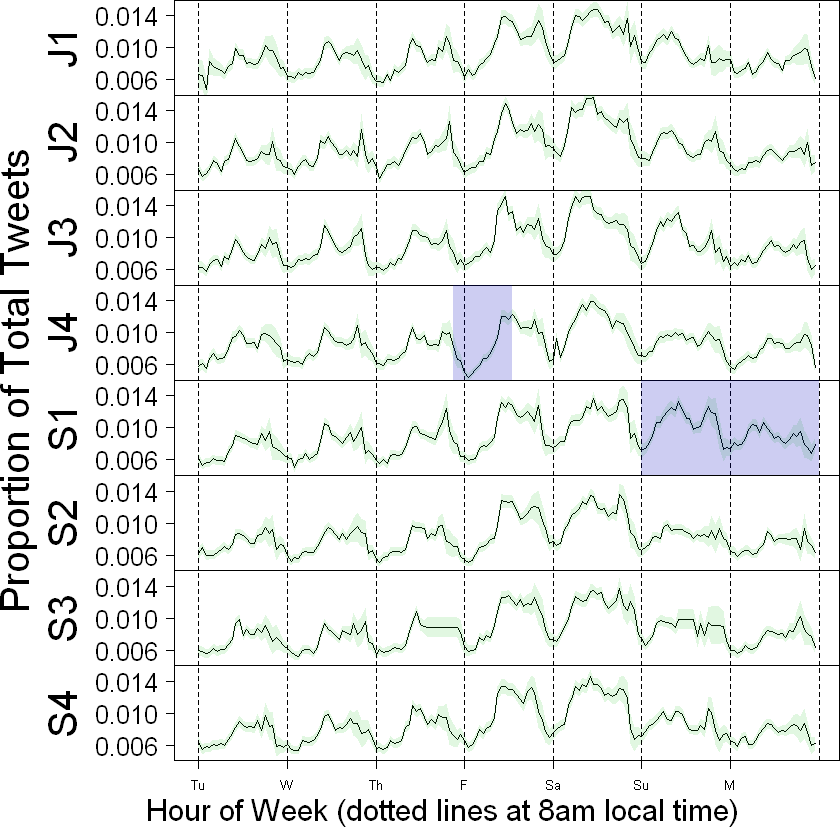

In [6]:
june = preprocessing(paste(data_dir,'/june/june_casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
june_cas = ts(june$series[33:(672+32)], frequency=24)
june_tot = ts(june$total[33:(672+32)], frequency=24)
june_perc <- june_cas/june_tot

sept = preprocessing(paste(data_dir,'/sept/sept_casual.csv', sep=''), paste(data_dir,'/sept/sept_total.csv', sep=''))
sept_cas = ts(sept$series[9:(672+8)], frequency=24)
sept_tot = ts(sept$total[9:(672+8)], frequency=24)
sept_perc <- sept_cas/sept_tot

sept.1 = as.numeric(window(sept_perc, start=c(1, 1), end= c(7, 24)))
sept.2 = as.numeric(window(sept_perc, start=c(8, 1), end= c(14, 24)))
sept.3 = as.numeric(window(sept_perc, start=c(15, 1), end= c(21, 24)))
sept.4 = as.numeric(window(sept_perc, start=c(22, 1), end= c(28, 24)))
june.1 = as.numeric(window(june_perc, start=c(1, 1), end= c(7, 24)))
june.2 = as.numeric(window(june_perc, start=c(8, 1), end= c(14, 24)))
june.3 = as.numeric(window(june_perc, start=c(15, 1), end= c(21, 24)))
june.4 = as.numeric(window(june_perc, start=c(22, 1), end= c(28, 24)))
weeks.perc = data.frame(june.1, june.2, june.3, june.4, sept.1, sept.2, sept.3, sept.4)

sept.t1 = as.numeric(window(sept_tot, start=c(1, 1), end= c(7, 24)))
sept.t2 = as.numeric(window(sept_tot, start=c(8, 1), end= c(14, 24)))
sept.t3 = as.numeric(window(sept_tot, start=c(15, 1), end= c(21, 24)))
sept.t4 = as.numeric(window(sept_tot, start=c(22, 1), end= c(28, 24)))
june.t1 = as.numeric(window(june_tot, start=c(1, 1), end= c(7, 24)))
june.t2 = as.numeric(window(june_tot, start=c(8, 1), end= c(14, 24)))
june.t3 = as.numeric(window(june_tot, start=c(15, 1), end= c(21, 24)))
june.t4 = as.numeric(window(june_tot, start=c(22, 1), end= c(28, 24)))
weeks.tot = data.frame(june.t1, june.t2, june.t3, june.t4, sept.t1, sept.t2, sept.t3, sept.t4)
                           

plot_weeks <- function(perc.df, tot.df){
    
    week_names = c('J1', 'J2', 'J3', 'J4', 'S1', 'S2', 'S3', 'S4')
    par(mfrow=c(8,1))
    # outer margin
    par(oma = c(5, 3, 0, 0))

    shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
    std_color <- rgb(0, 190, 0, alpha=30, maxColorValue=255)
    
    # plot each week
    for (col in 1:8){
        # remove space for x-axis
        par(mar = c(0, 8, 0, 0))
        yrange = c(0.0045, 0.0155)
        week.std = 1.96*series.std(perc.df[,col]*tot.df[,col], tot.df[,col])
        plot(perc.df[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='')
        above = perc.df[, col] + week.std
        below = perc.df[, col] - week.std
        polygon(c(1:168, rev(1:168)), c(above, rev(below)), col = std_color, border = NA)
        title(cex.lab =3, ylab=week_names[col], line=6)
        axis(2, labels = c('0.006', '0.010', '0.014'), at=c(0.006, 0.01, 0.014), las = 1, cex.axis=2)
        abline(v=seq(1, (168+24), by=24), lty=2)
        if (col==4){
            rect(xleft=70, xright=86, ybottom=(yrange[1]-0.005), ytop=(yrange[2]+0.005),col=shade_color, border=NA)
            }
        if (col==5){
            rect(xleft=(24*5+1), xright=(24*7+1), ybottom=(yrange[1]-0.005), ytop=(yrange[2]+0.005),col=shade_color, border=NA)
            }

    }

    mtext('Proportion of Total Tweets', cex=2, side = 2, outer = TRUE, line = 1)
    mtext('Hour of Week (dotted lines at 8am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
    axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)


}

plot_weeks(weeks.perc, weeks.tot)
pdf('c:/users/tom/documents/research/alc-plots/alc-series.pdf',width=6,height=12,paper='special') 
plot_weeks(weeks.perc, weeks.tot)
dev.off()

In [7]:
library('TSclust')
library('factoextra')

Warning message:
"package 'TSclust' was built under R version 3.3.3"Loading required package: wmtsa
Warning message:
"package 'wmtsa' was built under R version 3.3.3"Loading required package: pdc
Warning message:
"package 'pdc' was built under R version 3.3.3"Loading required package: cluster
Warning message:
"package 'factoextra' was built under R version 3.3.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"

In [8]:
june_over = preprocessing(paste(data_dir,'/age/summary/over/casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
june_under = preprocessing(paste(data_dir,'/age/summary/under/casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
tot = ts((june_over$total)[(49-16):(24*30-16)], frequency=24)
jo = ts((june_over$series)[(49-16):(24*30-16)], frequency=24)
ju = ts((june_under$series)[(49-16):(24*30-16)], frequency=24)

o.1 = as.numeric(window(jo, start=c(1, 1), end= c(7, 24)))
o.2 = as.numeric(window(jo, start=c(8, 1), end= c(14, 24)))
o.3 = as.numeric(window(jo, start=c(15, 1), end= c(21, 24)))
o.4 = as.numeric(window(jo, start=c(22, 1), end= c(28, 24)))
u.1 = as.numeric(window(ju, start=c(1, 1), end= c(7, 24)))
u.2 = as.numeric(window(ju, start=c(8, 1), end= c(14, 24)))
u.3 = as.numeric(window(ju, start=c(15, 1), end= c(21, 24)))
u.4 = as.numeric(window(ju, start=c(22, 1), end= c(28, 24)))

t.1 = as.numeric(window(tot, start=c(1, 1), end= c(7, 24)))
t.2 = as.numeric(window(tot, start=c(8, 1), end= c(14, 24)))
t.3 = as.numeric(window(tot, start=c(15, 1), end= c(21, 24)))
t.4 = as.numeric(window(tot, start=c(22, 1), end= c(28, 24)))


weeks.o = data.frame(o.1, o.2, o.3, o.4)
weeks.u = data.frame(u.1, u.2, u.3, u.4)
weeks.t = data.frame(t.1, t.2, t.3, t.4)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


png 
  2

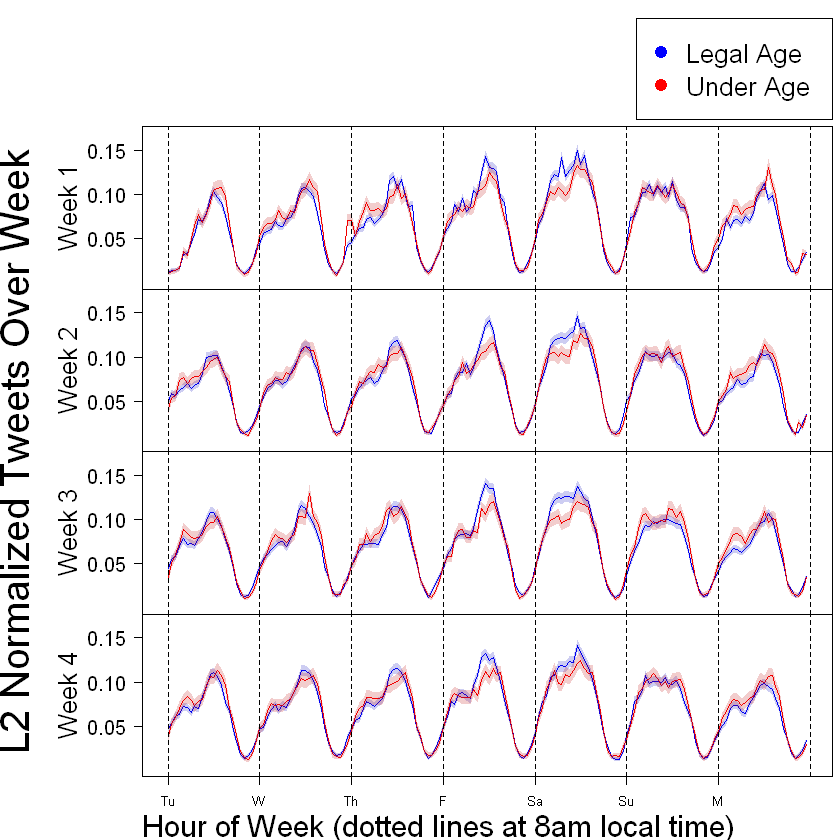

In [9]:
over_under_plot <- function(weeks.o, weeks.u, weeks.t){
    normalize <- function(ts){
        return(ts/norm(ts, type='2'))
    }
    # overage series, underage series, total tweets
    normed_weeks.o = apply(weeks.o, 2, normalize)
    normed_weeks.u = apply(weeks.u, 2, normalize)
    week_names = c('Week 1', 'Week 2', 'Week 3', 'Week 4')
    par(mfrow=c(4,1))
    # outer margin
    par(oma = c(4, 3, 8, 0.5))
    under_color <- rgb(190, 0, 0, alpha=50, maxColorValue=255)
    over_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
    for (col in 1:4){
        # remove space for x-axis
        yrange = c(0, 0.17)
        par(mar = c(0, 6, 0, 0))
        o.std = 1.96*series.std(weeks.o[,col], weeks.t[,col])*weeks.t[,col]/norm(weeks.o[,col], type='2')
        o.above = normed_weeks.o[, col] + o.std
        o.below = normed_weeks.o[, col] - o.std
        
        u.std = 1.96*series.std(weeks.u[,col], weeks.t[,col])*weeks.t[,col]/norm(weeks.u[,col], type='2')
        u.above = normed_weeks.u[, col] + u.std
        u.below = normed_weeks.u[, col] - u.std
        
        plot(normed_weeks.o[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='', col='blue')
        lines(normed_weeks.u[, col], col='red')
        polygon(c(1:168, rev(1:168)), c(o.above, rev(o.below)), col = over_color, border = NA)
        polygon(c(1:168, rev(1:168)), c(u.above, rev(u.below)), col = under_color, border = NA)
        
        title(ylab=week_names[col], line=4, las=1, cex.lab=2)
        axis(2, labels = c('0.05', '0.10', '0.15'), at=c(0.05, 0.1, 0.15), las = 1, cex.axis=1.5)
        abline(v=seq(1, (168+24), by=24), lty=2)
    }

    mtext('L2 Normalized Tweets Over Week', side = 2, outer = TRUE, line = 1, cex=2)
    mtext('Hour of Week (dotted lines at 8am local time)', side = 1, outer = TRUE, line = 3, cex=1.5)
    axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)
    par(xpd=NA)
    legend(123.5,0.85,
       c("Legal Age", "Under Age"),
       col = c("blue", "red"),
       cex = 2, pch=19)


}
over_under_plot(weeks.o, weeks.u, weeks.t)

pdf('c:/users/tom/documents/research/alc-plots/age-plot.pdf',width=7,height=8,paper='special') 
over_under_plot(weeks.o, weeks.u, weeks.t)
dev.off()

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


png 
  2

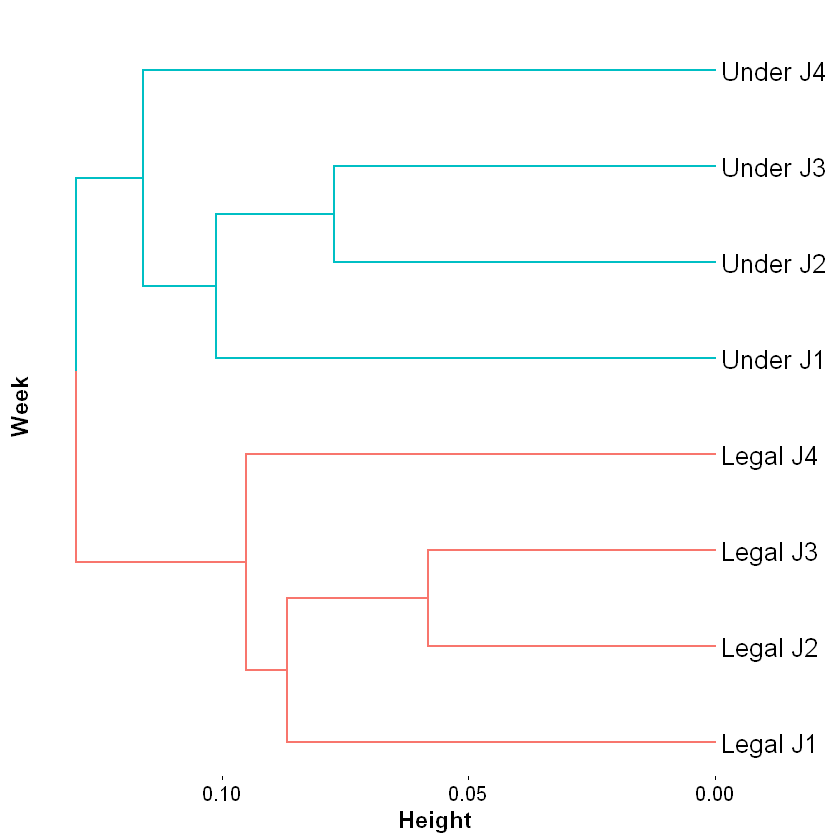

In [107]:
age_clust <- function(){
    normalize <- function(ts){
            return(ts/norm(ts, type='2'))
        }
    june_over = preprocessing(paste(data_dir,'/age/summary/over/casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
    june_under = preprocessing(paste(data_dir,'/age/summary/under/casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
    tot = ts((june_over$total)[(49):(672+49)], frequency=24)
    jo = ts((june_over$series)[(49):(672+49)], frequency=24)
    ju = ts((june_under$series)[(49):(672+49)], frequency=24)

    o.1 = as.numeric(window(jo, start=c(1, 1), end= c(7, 24)))
    o.2 = as.numeric(window(jo, start=c(8, 1), end= c(14, 24)))
    o.3 = as.numeric(window(jo, start=c(15, 1), end= c(21, 24)))
    o.4 = as.numeric(window(jo, start=c(22, 1), end= c(28, 24)))
    u.1 = as.numeric(window(ju, start=c(1, 1), end= c(7, 24)))
    u.2 = as.numeric(window(ju, start=c(8, 1), end= c(14, 24)))
    u.3 = as.numeric(window(ju, start=c(15, 1), end= c(21, 24)))
    u.4 = as.numeric(window(ju, start=c(22, 1), end= c(28, 24)))


    weeks = data.frame(o.1, o.2, o.3, o.4, u.1, u.2, u.3, u.4)
    colnames(weeks) = c('Legal J1', 'Legal J2', 'Legal J3', 'Legal J4', 'Under J1','Under J2','Under J3','Under J4')
    dist = diss(t(apply(weeks, 2, normalize)), METHOD='EUCL')

    par(mar=c(5.1,4.1,4.1,3.1))
    a = agnes(dist)
    p <- fviz_dend(a,  main='', ylab='Height', xlab='Week',  k=2, label_col='black', las=1, horiz=TRUE, cex=1.1) 
    p <- p + theme(axis.title=element_text(size=14,face="bold"))
    p
}
age_clust()

pdf('c:/users/tom/documents/research/alc-plots/age-dend.pdf',width=7,height=4,paper='special') 
age_clust()
dev.off()

# Shisha plots

In [16]:
preprocessing_df <- function(ts, total, thres=5000){
  
  # removes rows with low observations and locfs them
  # returns time series and total time series, as a list
  
  df = time_index(data.frame(ts))
  df_total = time_index(data.frame(total))
  
  missing = df_total[,'tweets']<thres
  print(which(missing))
  df_total[missing, 'tweets'] <- NA
  df[missing,] <-NA
  df_total = na.locf(df_total[,'tweets'])
  df_filled = (na.locf(df[, ncol(df)]))
  
  return(list(series=df_filled, total=df_total))
}

In [17]:
split_by_day <- function(ts_month){
  # ts_month: vector-like of hourly observations over month
  # returns matrix where cols are "days" and rows are hours
  days = data.frame(matrix(nrow=24, ncol=1))
  for (i in 1:(length(ts_month)/24)){
    days[[i]] = ts_month[((i-1)*24+1):(i*24)]
  }
  return(days)
}

In [74]:
plot_prop_sum <- function(scsv, fcsv, sept.shish_csv, sept.fp_csv, type='Present', dend=FALSE){
    j_shi <- read.csv(scsv)
    j_tob <- read.csv(fcsv)
    presj <- j_tob[c(1,2,3)]
    totj <- j_tob[c(1,2,4)]
    shij <- j_shi[c(1,2,3)]
    newj <- preprocessing_df(presj, totj)
    new_shij <- preprocessing_df(shij, totj)
    ts_jpres <- ts((new_shij$series/newj$series)[33:(672+32)], frequency=24)
    ts_jpres[is.na(ts_jpres)] <- 0 
    
    # sept
    s_shi <- read.csv(sept.shish_csv)
    s_tob <- read.csv(sept.fp_csv)
    press <- s_tob[c(1,2,3)]
    tots <- s_tob[c(1,2,4)]
    shis <- s_shi[c(1,2,3)]
    news <- preprocessing_df(press, tots)
    new_shis <- preprocessing_df(shis, tots)
    ts_spres <- ts((new_shis$series/news$series)[9:(672+8)], frequency=24)
    ts_spres[is.na(ts_spres)] <- 0 
    
    pres.1 = as.numeric(window(ts_jpres, start=c(1, 1), end= c(7, 24)))
    pres.2 = as.numeric(window(ts_jpres, start=c(8, 1), end= c(14, 24)))
    pres.3 = as.numeric(window(ts_jpres, start=c(15, 1), end= c(21, 24)))
    pres.4 = as.numeric(window(ts_jpres, start=c(22, 1), end= c(28, 24)))
    spres.1 = as.numeric(window(ts_spres, start=c(1, 1), end= c(7, 24)))
    spres.2 = as.numeric(window(ts_spres, start=c(8, 1), end= c(14, 24)))
    spres.3 = as.numeric(window(ts_spres, start=c(15, 1), end= c(21, 24)))
    spres.4 = as.numeric(window(ts_spres, start=c(22, 1), end= c(28, 24)))
    c.ts = data.frame(pres.1, pres.2, pres.3, pres.4, spres.1, spres.2, spres.3, spres.4)
    c.ts[is.na(c.ts)] <- 0
    
    proportion.ts <- (rowSums(c.ts))/8
    
    if (!dend){
        quant.ts <- apply(c.ts, 1, quantile)
        low <- quant.ts['25%',]
        high <- quant.ts['75%',]

        shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
        # 
        plot(proportion.ts, type='l', xaxt='n', xlab='Hour of Week (dotted lines at 8am local time)',
             ylab=paste('Proportion of', type, 'Current Tweets'), ylim=c(0, 0.2))
        polygon(c(1:168, rev(1:168)), c(high, rev(low)), col = shade_color, border = NA)
        abline(v=seq(1, 168, by=24), lty=2)
        axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24))
        
        legend('topright',
           c("Mean", "25%-75% quantile"),
           col = c("black", shade_color),
           cex = 0.6, pch=c(NA, 15), lty = c(1, 0))
    }
    else{
        # dendogram
        weekdays = c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M')
        june_days = split_by_day(proportion.ts)
        colnames(june_days)=weekdays
        dist = diss(june_days, METHOD = 'EUCL')
        c = agnes(dist, diss=TRUE)
        p <- fviz_dend(c, rect=TRUE, k=2, main='', ylab='Height', xlab='Day of Week', 
                  cex=1.2, label_col='black', horiz=TRUE) 
        p <- p + theme(axis.title=element_text(size=14,face="bold")) + ylim(0.3, -0.01)
        p
        
    
    }
}

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_rect)."

png 
  2

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_rect)."

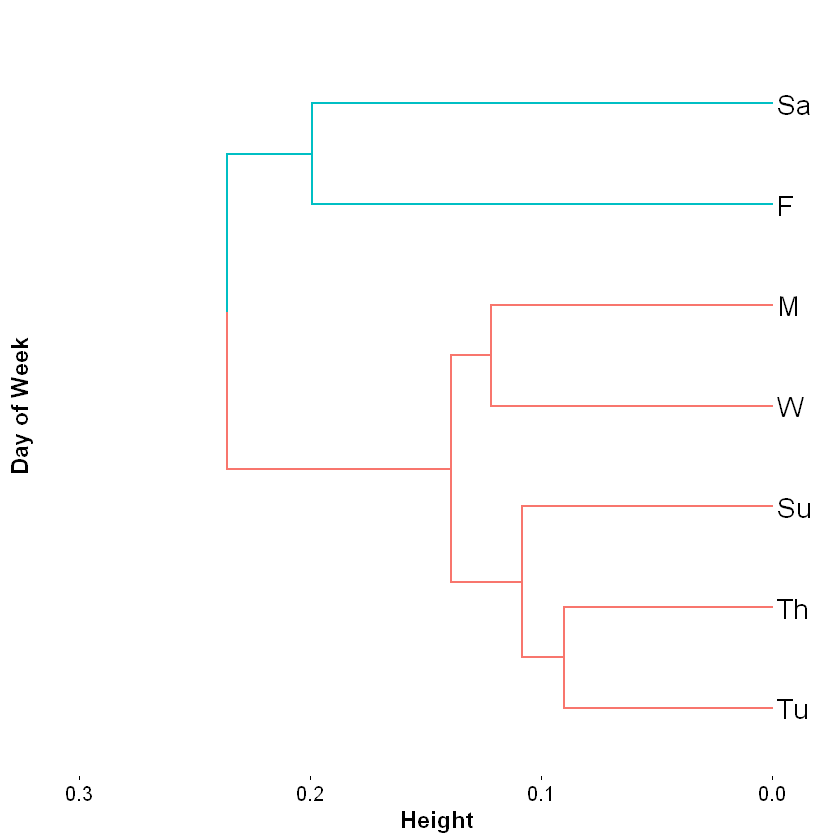

In [108]:
pdf('c:/users/tom/documents/research/alc-plots/present-dend.pdf',width=7,height=4,paper='special') 
plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/present.csv', 
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/present.csv', type='Present', dend=TRUE)
dev.off()
plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/present.csv', 
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/present.csv', type='Present', dend=TRUE)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


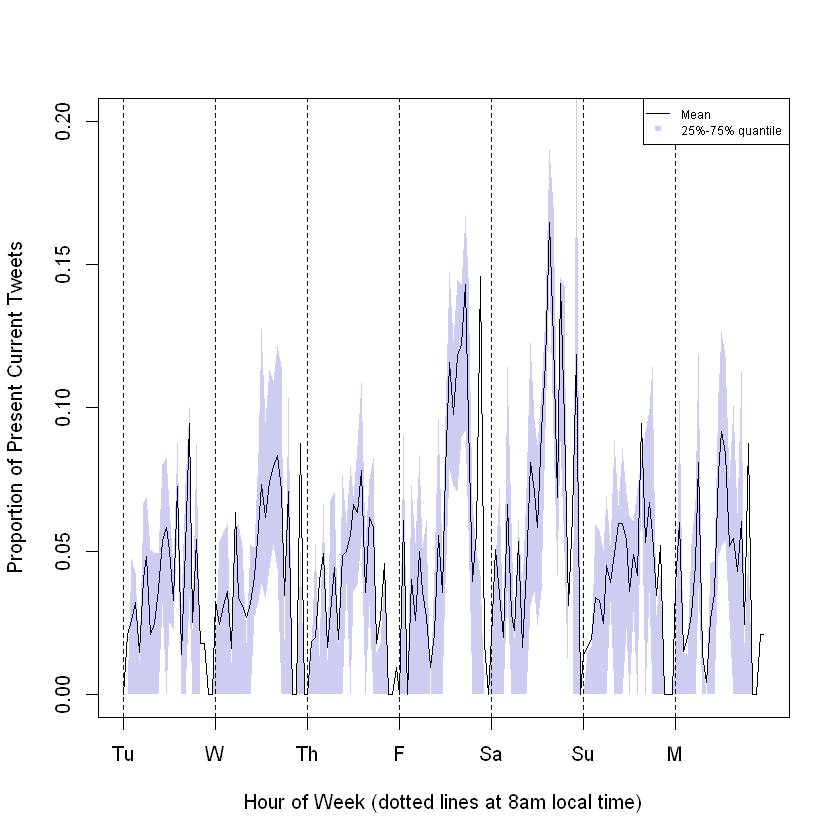

In [33]:
plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/present.csv', 
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/present.csv', type='Present')

# pdf('c:/users/tom/documents/research/alc-plots/present-shisha-sum-prop.pdf',width=7,height=4,paper='special') 
# plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/shisha.csv',
#               'c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/present.csv', 
#               'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/shisha.csv',
#               'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/present.csv', type='Present')
# dev.off()

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_rect)."

png 
  2

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_rect)."

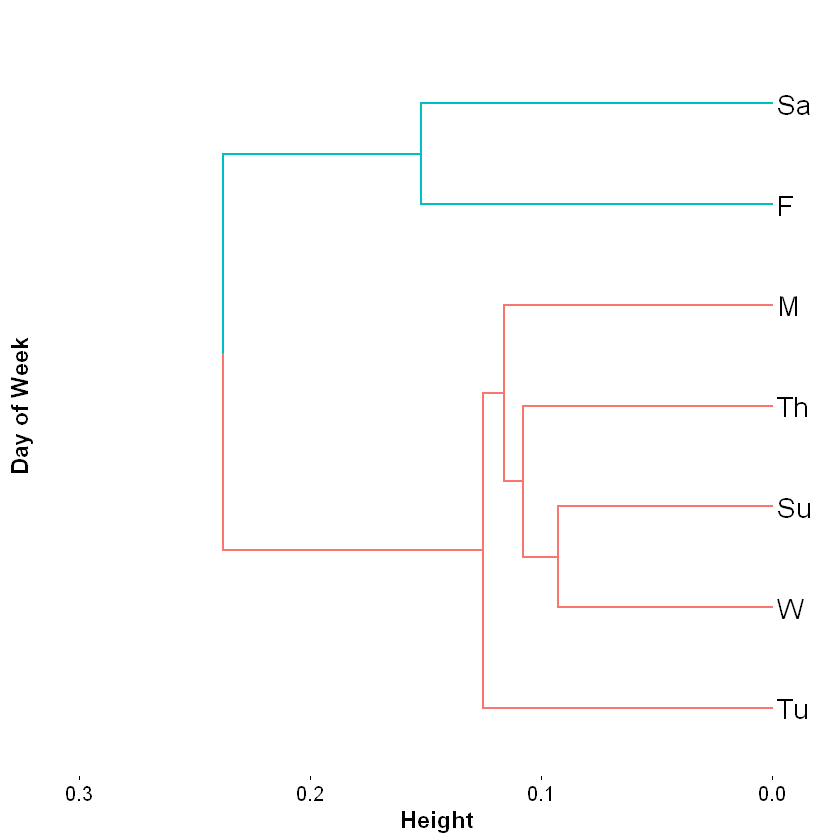

In [106]:
pdf('c:/users/tom/documents/research/alc-plots/current-dend.pdf',width=7,height=4,paper='special') 
plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary-cur/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/june/summary-cur/summary/current.csv', 
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary-cur/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary-cur/summary/current.csv', type='Current', dend=TRUE)
dev.off()
plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary-cur/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/june/summary-cur/summary/current.csv', 
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary-cur/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary-cur/summary/current.csv', type='Current', dend=TRUE)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


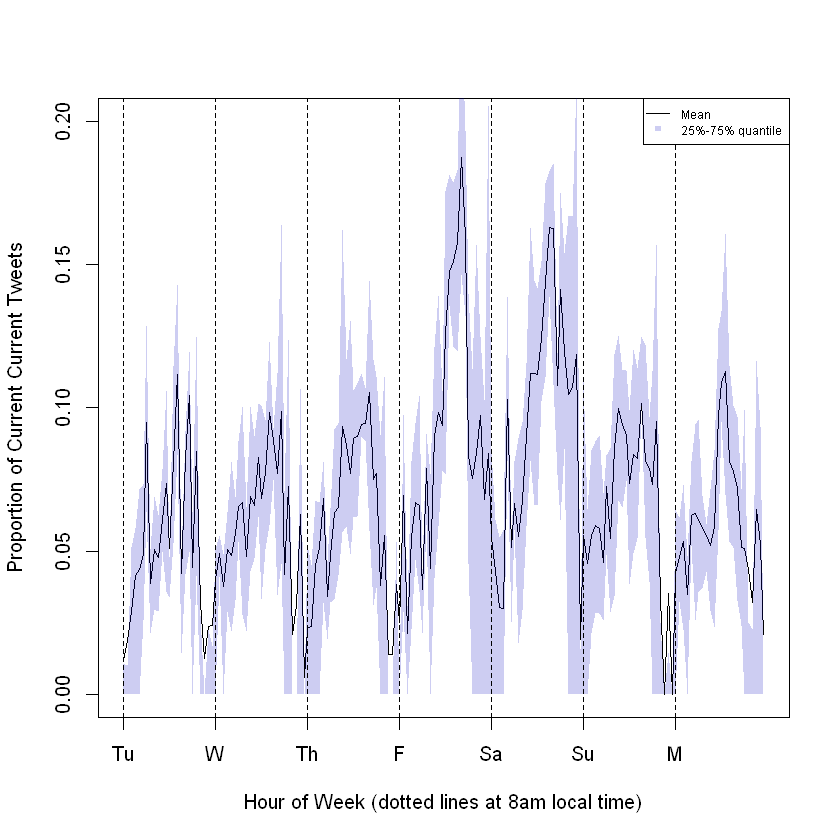

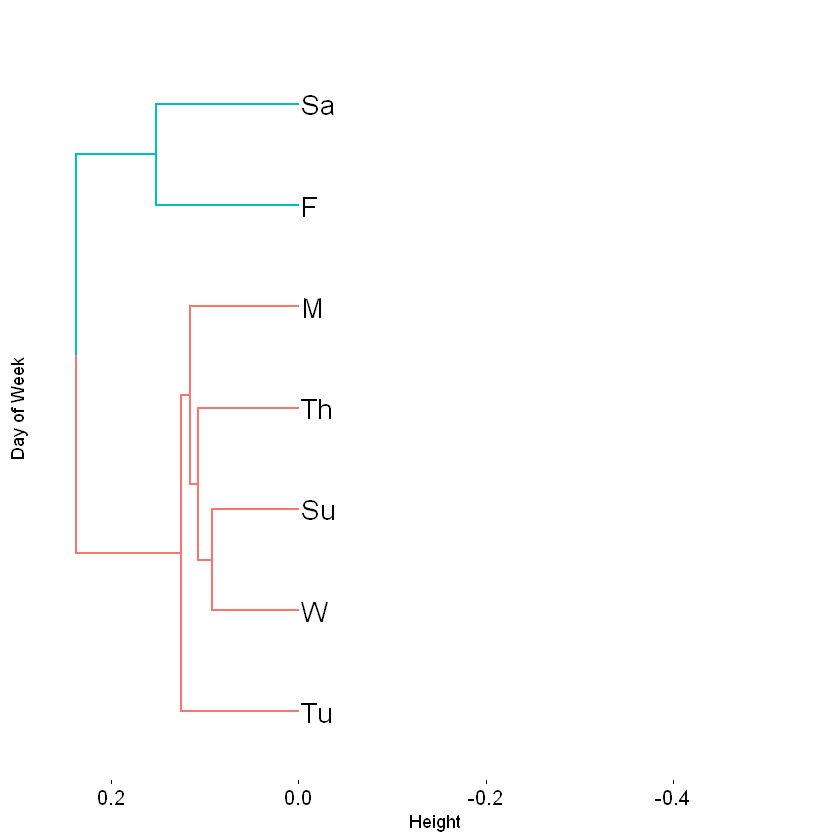

In [31]:
plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary-cur/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/june/summary-cur/summary/current.csv', 
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary-cur/summary/shisha.csv',
              'c:/users/tom/documents/nyu-test/tob-run2/sept/summary-cur/summary/current.csv', type='Current')

# pdf('c:/users/tom/documents/research/alc-plots/present-shisha-sum-prop.pdf',width=7,height=4,paper='special') 
# plot_prop_sum('c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/shisha.csv',
#               'c:/users/tom/documents/nyu-test/tob-run2/june/summary/summary/present.csv', 
#               'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/shisha.csv',
#               'c:/users/tom/documents/nyu-test/tob-run2/sept/summary/summary/present.csv', type='Present')
# dev.off()

In [83]:
library(ggplot2)

png 
  2

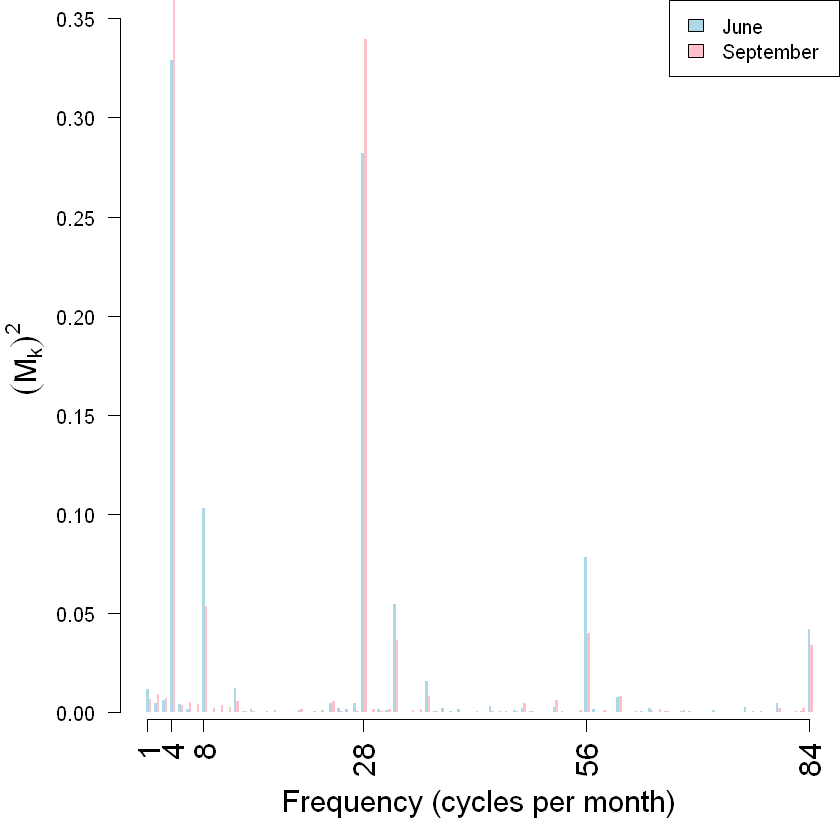

In [125]:
plot_dft <- function(j.ts, s.ts){
#     par(mfrow=c(2,1))
    par(mar = c(5, 5, 0, 0))
    j.trans = Mod(fft(j.ts)[2:(28*3+1)])^2
    s.trans = Mod(fft(s.ts)[2:(28*3+1)])^2
    df = data.frame(j.trans, s.trans)
    colors = c("lightblue","pink")
    per = barplot(t(df), beside=T, xlab='Frequency (cycles per month)', cex.lab=1.5, las=1, col=colors, border=NA)
    title(ylab=expression(('M'['k'])^2), cex.lab=1.5)
    interesting = c(1, 4, 8, 28, 56, 84)
    axis(1, at=per[interesting*2-1], labels=interesting, las=2, cex.axis=1.5)
    legend("topright", legend=c("June", "September"), fill=colors)
}
plot_dft(june_perc, sept_perc)
pdf('c:/users/tom/documents/research/alc-plots/dft.pdf',width=7,height=4,paper='special') 
plot_dft(june_perc, sept_perc)
dev.off()

In [111]:
library(Rwave)

Warning message:
"package 'Rwave' was built under R version 3.3.3"

In [118]:
plot_morlet <- function(ts){
    m = cwt(ts, noctave=7, w0=(2*pi), nvoice=20, plot=FALSE)
    component=43
    
    shade_color <- rgb(0, 0, 190, alpha=35, maxColorValue=255)

    # outer margin
    par(oma = c(5, 3, 0, 0))
    par(mar = c(0, 6, 0, 0))

    # wavelet transform
    plot(Re(m[,component]), type='l', xaxt='n', ylab='', las=1, cex.axis=1.2)
    yrange=par("yaxp")[1:2]
    title(cex.lab =1.5, ylab=expression(paste('Re[','W'['n'], '(s)]')), line=4)
    abline(v=seq(1, (29*24), by=(24*7)), lty=2)
    axis(1, labels = rep(c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'),4), at=seq(1, (24*28), by=24), outer=TRUE, las=2, cex.lab=2)
    #highlight
    yrange=par("yaxp")[1:2]
    for (week in 0:3){
    rect(xleft=(24*4+168*week), xright=(24*6+168*week), ybottom=(yrange[1]-0.005), ytop=(yrange[2]+0.005),col=shade_color, border=NA)
        }
    mtext('Hour of Week (dotted lines weekly at Tu 8am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
}

png 
  2

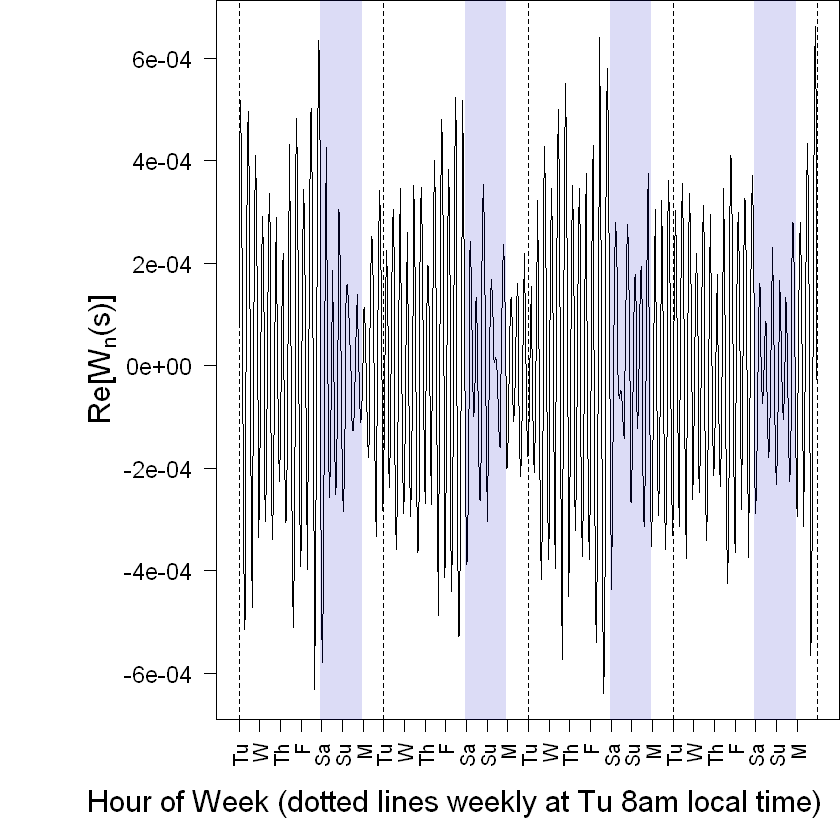

In [120]:
pdf('c:/users/tom/documents/research/alc-plots/wavelet.pdf',width=7,height=4,paper='special') 
plot_morlet(june_perc)
dev.off()
plot_morlet(june_perc)